# Imports

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram

# Experimental Setup

Note: Throughout this notebook we consider vertically polarized light as $\ket{0}$ and horizontally polarized light as $\ket{1}$. We also refer detection site A as "Alice" and site B as "Bob" following standard quantum information theory language.

First, we illumitate a 440-nm lazer and on a pair of Barium Borate(BBO) crystals to produced pairs of entangled photons with a wavelength $\approx$ 880-nm. The light polarization of the light should be at $45^{\circ}$ with respect to one of the BBO crystal's axis. To learn more please read the referred paper. Then, we need to do the following:
1. Check the purity of the entanled pair by doing 4 measurements. $N(0^{\circ}, 0^{\circ}), N(90^{\circ}, 90^{\circ}), N(45^{\circ}, 45^{\circ}), N(0^{\circ}, 90^{\circ})$.
2. Perform 16 measurements for each $(\alpha, \beta)$ as mentioned in Table-1 in the paper.
3. Calculate $E(a,b), E(a,b'), E(a',b), E(a',b')$ using 
$$E(\alpha, \beta) = \frac{ N(\alpha, \beta) + N(\alpha_{\perp}, \beta_{\perp}) - N(\alpha, \beta_{\perp}) - N(\alpha_{\perp}, \beta) }{ N(\alpha, \beta) + N(\alpha_{\perp}, \beta_{\perp}) + N(\alpha, \beta_{\perp}) + N(\alpha_{\perp}, \beta) }$$
4. Calculate S using $$S = E(a,b) - E(a,b') + E(a',b) + E(a',b')$$

# Creating the circuits

## Entangled pair

To create an entangled pair of photons i.e the $\psi_{\text{EPR}} = \frac{1}{\sqrt{2}} (\ket{00} + \ket{11})$ state we use the following circuit to create this Bell's state.

In [2]:
alice_qbit = QuantumRegister(1, name="Alice's qubit")
bob_qbit = QuantumRegister(1, name="Bob's qubit")

def create_epr_state():
    epr_qc = QuantumCircuit(alice_qbit, bob_qbit)
    epr_qc.h(0)
    epr_qc.cx(0, 1)
    return epr_qc

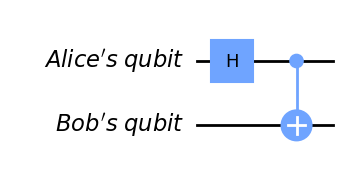

In [3]:
epr_qc = create_epr_state()
epr_qc.draw("mpl", style="clifford")

## Adding polarizors with arbitrary angle

We now need a way to measure these qubits in an arbitrary basis. For this, we just need to perform $R_{y}(\theta)$ before measurement, where $\theta$ can be chosen independently by Alice and Bob. Let $\alpha$ and $\beta$ be the angle of the basis chosen by Alice and Bob respectively.

In [4]:
alpha_param = Parameter('α')
beta_param = Parameter('β')
alice_mes = ClassicalRegister(1, name="Alice_mes")
bob_mes = ClassicalRegister(1, name="Bob_mes")

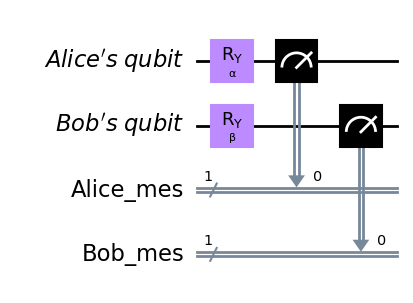

In [5]:
def choose_basis_and_measure():
    qc = QuantumCircuit(alice_qbit, bob_qbit, alice_mes, bob_mes)
    qc.ry(alpha_param, alice_qbit)
    qc.ry(beta_param, bob_qbit)
    qc.measure(alice_qbit, alice_mes)
    qc.measure(bob_qbit, bob_mes)
    return qc

add_pol_qc = choose_basis_and_measure()
add_pol_qc.draw("mpl", style="clifford")

## Join these circuits to get the full parametrized circuit

In [6]:
def bells_inequality_qc():
    qc = QuantumCircuit(alice_qbit, bob_qbit, alice_mes, bob_mes)
    qc = qc.compose(create_epr_state())
    qc = qc.compose(choose_basis_and_measure())
    return qc

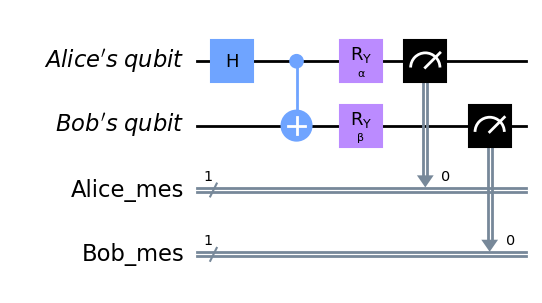

In [7]:
experiment_qc = bells_inequality_qc()
experiment_qc.draw("mpl", style="clifford")

# Create simulator instance

In [8]:
simulator = Aer.get_backend('aer_simulator')
experiment_qc = transpile(experiment_qc, simulator)
shots = 100000

# Confirm $\psi_{\text{EPR}}$ state

In [9]:
polraization_angles = ( (0, 0), (90, 90), (45, 45), (0, 90) )

In [10]:
def convert_to_radians(degrees):
    return degrees * np.pi/180

def convert_to_degrees(radians):
    return radians * 180/np.pi

def convert_polarizer_angle_to_ry_angle(theta):
    return convert_to_radians(2 * theta)

In [11]:
def get_coincidences(job):
    result = job.result()
    counts = result.get_counts()    
    coinicidences = counts.get('1 1', 0)
    return coinicidences

Note: Here we could have counted both `0 0` and `1 1` for coincidences. But, since we are trying to mimic the experiment where we have a photon detector I have taken only `1 1`. Using a sum of these two will yield similar results. 

In [12]:
N_coinicidences_epr = {}
for alpha_beta in polraization_angles:
    alpha_polarization_angle, beta_polarization_angle = alpha_beta
    alpha = convert_polarizer_angle_to_ry_angle(alpha_polarization_angle)
    beta = convert_polarizer_angle_to_ry_angle(beta_polarization_angle)
    job = simulator.run(experiment_qc.assign_parameters({ alpha_param: alpha, beta_param: beta }), shots=shots)
    coinicidences = get_coincidences(job)
    N_coinicidences_epr[alpha_beta] = coinicidences

In [13]:
N_coinicidences_epr

{(0, 0): 50095, (90, 90): 49989, (45, 45): 49875, (0, 90): 0}

$$C = N(0^{\circ}, 90^{\circ})$$
$$A = N(0^{\circ}, 0^{\circ}) + N(90^{\circ}, 90^{\circ}) - 2C $$

In [14]:
C = N_coinicidences_epr[(0, 90)]
C

0

Though C is ideally 0 in our experiment we are going to have some counts but they should be much smaller than A.

In [15]:
A = N_coinicidences_epr[(0, 0)] +  N_coinicidences_epr[(90, 90)] - 2*C
A

100084

$$\tan^{2} \theta_{l} = \frac{N(90^{\circ}, 90^{\circ}) - C}{N(0^{\circ}, 0^{\circ}) - C}$$

In [16]:
rhs = (N_coinicidences_epr[(90, 90)] - C) / (N_coinicidences_epr[(0, 0)] - C)
rhs

0.9978840203613135

In [17]:
convert_to_degrees(np.arctan(np.sqrt(rhs)))

44.969658717857925

Therefore $\theta_{l} \approx 45$. The experimental value should be close to this value if you have a pure $\psi_{\text{EPR}}$.

$$\cos\phi_{m} = \frac{1}{\sin 2 \theta_{l}} \left( 4 \frac{N(45^{\circ}, 45^{\circ}) - C}{A} - 1\right)$$

In [44]:
rhs = (1/np.sin(2 * convert_to_radians(45))) * ((4*(N_coinicidences_epr[(45, 45)] - C)/A) - 1)
rhs

0.993325606490548

In [45]:
convert_to_degrees(np.arccos(rhs))

6.6234671214525855

Note: I am not if I did something wrong but $\phi_{m} \approx 6.6^{\circ}$ according to simulation but the experimental value according to the paper it is $26^{\circ}$.

# 16 measurements to calculate S

In [20]:
alphas_polarization_angles = np.arange(-45, 90 + 45, 45)
beta_polarization_angles = np.arange(-22.5, 90 + 45, 45)

In [21]:
alphas_polarization_angles

array([-45,   0,  45,  90])

In [22]:
beta_polarization_angles

array([-22.5,  22.5,  67.5, 112.5])

In [23]:
N_AB = {}
for alpha_polarization_angle in alphas_polarization_angles:
    for beta_polarization_angle in beta_polarization_angles:
        alpha = convert_polarizer_angle_to_ry_angle(alpha_polarization_angle)
        beta = convert_polarizer_angle_to_ry_angle(beta_polarization_angle)
        job = simulator.run(experiment_qc.assign_parameters({ alpha_param: alpha, beta_param: beta }), shots=shots)
        coinicidences = get_coincidences(job)
        N_AB[(alpha_polarization_angle, beta_polarization_angle)] = coinicidences

In [24]:
for alpha_beta, exp_val in N_AB.items():
    print(f"{alpha_beta}: {exp_val}")

(-45, -22.5): 42956
(-45, 22.5): 7415
(-45, 67.5): 7397
(-45, 112.5): 42563
(0, -22.5): 42373
(0, 22.5): 42716
(0, 67.5): 7148
(0, 112.5): 7478
(45, -22.5): 7151
(45, 22.5): 42816
(45, 67.5): 42815
(45, 112.5): 7359
(90, -22.5): 7334
(90, 22.5): 7309
(90, 67.5): 42689
(90, 112.5): 42638


In [25]:
a = -45
a_prime = a + 45
b = -22.5
b_prime = b + 45

## Calculate Es

In [26]:
def E(alpha, beta):
    alpha_perp = alpha + 90
    beta_perp = beta + 90
    num = N_AB[(alpha, beta)] + N_AB[(alpha_perp, beta_perp)] - N_AB[(alpha, beta_perp)] - N_AB[(alpha_perp, beta)]
    den = N_AB[(alpha, beta)] + N_AB[(alpha_perp, beta_perp)] + N_AB[(alpha, beta_perp)] + N_AB[(alpha_perp, beta)]
    return num/den

In [27]:
E(a, b)

0.7099652109769834

In [28]:
E(a, b_prime)

-0.7049713937675357

In [29]:
E(a_prime, b)

0.7090331913525677

In [30]:
E(a_prime, b_prime)

0.7046764062671633

# Calculate S

$$S = E(a,b) - E(a,b') + E(a',b) + E(a',b')$$

In [31]:
def calculate_s(a, b, a_prime, b_prime):
    return E(a, b) - E(a, b_prime) + E(a_prime, b) + E(a_prime, b_prime)

In [32]:
calculate_s(a, b, a_prime, b_prime)

2.82864620236425

In [33]:
2 * np.sqrt(2)

2.8284271247461903